In [1]:
import sys
import os
import struct
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_plotting_defaults()
from utils import roi_utils

In [2]:
# Load results of the fitting procedure

subject = 1
volume_space=True
# fitting_type = 'gabor_solo_ridge_4ori_4sf'
fitting_type = 'gabor_solo_ridge_12ori_8sf'
# fitting_type = 'gabor_solo_ridge_12ori_8sf_SHUFFLEIMAGES'

root = os.path.dirname(os.path.dirname(os.getcwd()))
out, fig_save_folder = load_fits.load_fit_results(subject, volume_space, fitting_type, \
                                                  n_from_end=0, root=root, verbose=True);
load_fits.print_output_summary(out)

if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01/gabor_solo_ridge_12ori_8sf/Nov-13-2021_1355_40/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_type', 'fitting_type2', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'aperture', 'aperture_rf_range', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'zscore_in_groups', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'corr_each_feature', 'discrim_each_axis', 'feature_table_simple', 'filter_pars_simple', 'orient_filters_simple', 'feature_table_complex', 'filter_pars_complex', 'orient_filters_complex', 'feature_types_exclude', 'feature_info', 'autocorr_output_pix', 'group_all_hl_feats', 'gabor_nonlin_fn'])
subject = 1
volume_space = 1
fitting_type = gabor_solo
voxel_mask: shape (699192,)
brain_nii_shape: shape (3,)
image_or

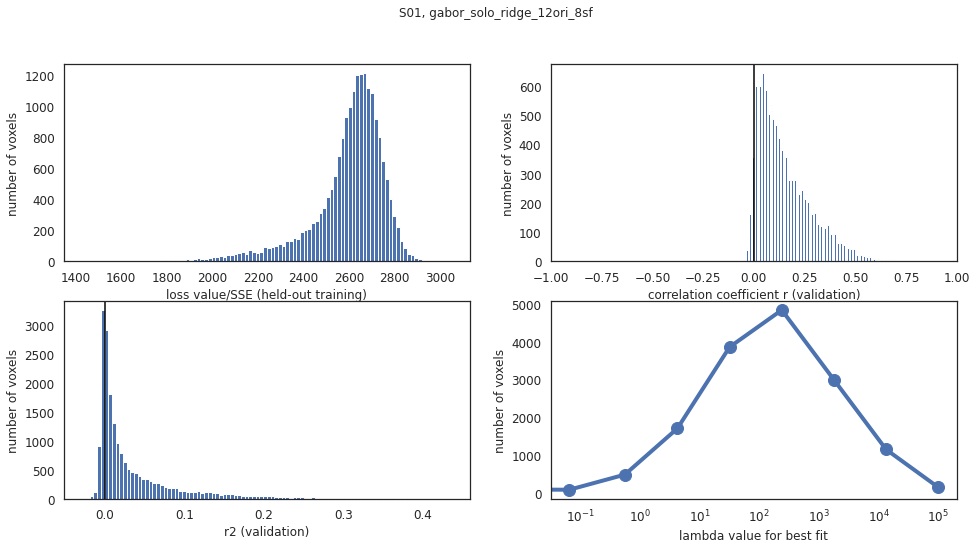

In [192]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_perf_summary(subject, fitting_type, out, fig_save_folder=fig_save_folder)

In [3]:
roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=True,volume_space=True,verbose=False) 
# roi_def = roi_utils.get_combined_rois(subject,include_all=False,include_body=False,volume_space=True,verbose=False) 

skip_inds = [10,11,15,23]
retlabs, facelabs, placelabs, bodylabs, \
        ret_names, face_names, place_names, body_names = roi_def


In [6]:
# plot_utils.plot_fit_summary_volume_space(subject, fitting_type,out, fig_save_folder)

In [ ]:
summary_plots.plot_summary_pycortex(subject, fitting_type, out, roi_def=roi_def, port=33333)

Data is in 3d volume space
navigate browser to: 127.0.0.1:33333
Started server on port 33333


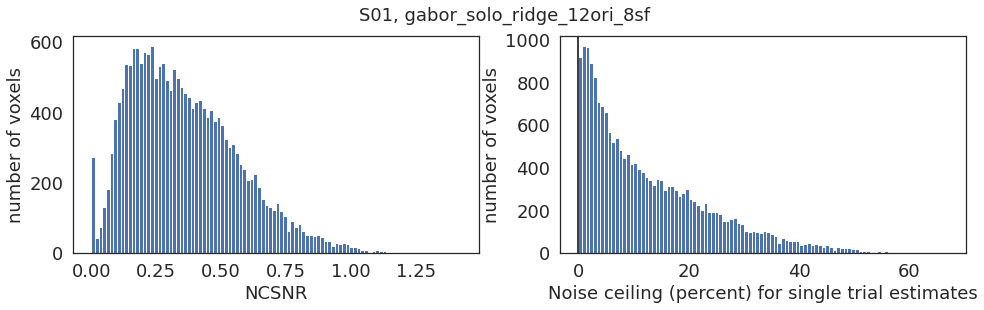

In [21]:
plot_utils.set_all_font_sizes(fs = 18)
summary_plots.plot_noise_ceilings(subject, fitting_type,out, fig_save_folder)

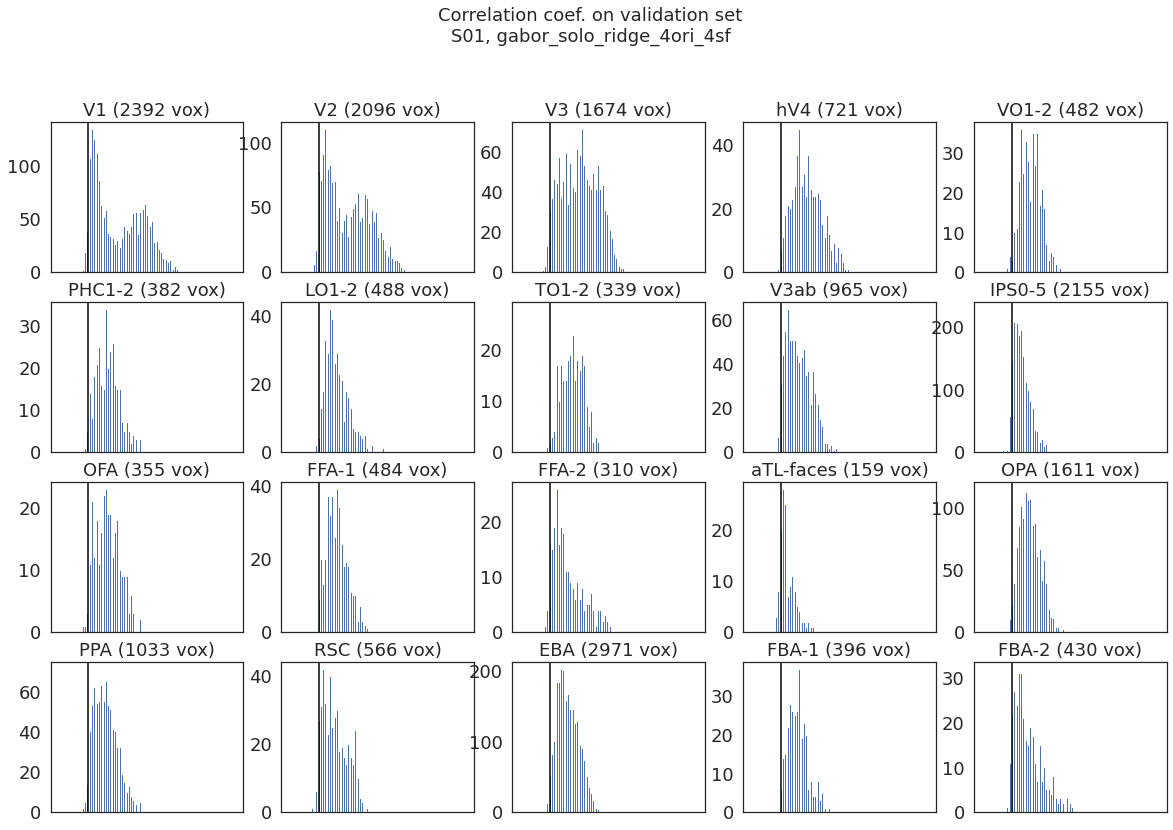

In [155]:
plot_utils.set_all_font_sizes(fs = 18)
summary_plots.plot_cc_each_roi(subject, fitting_type,out, roi_def=roi_def, skip_inds=skip_inds, \
                               fig_save_folder=fig_save_folder)

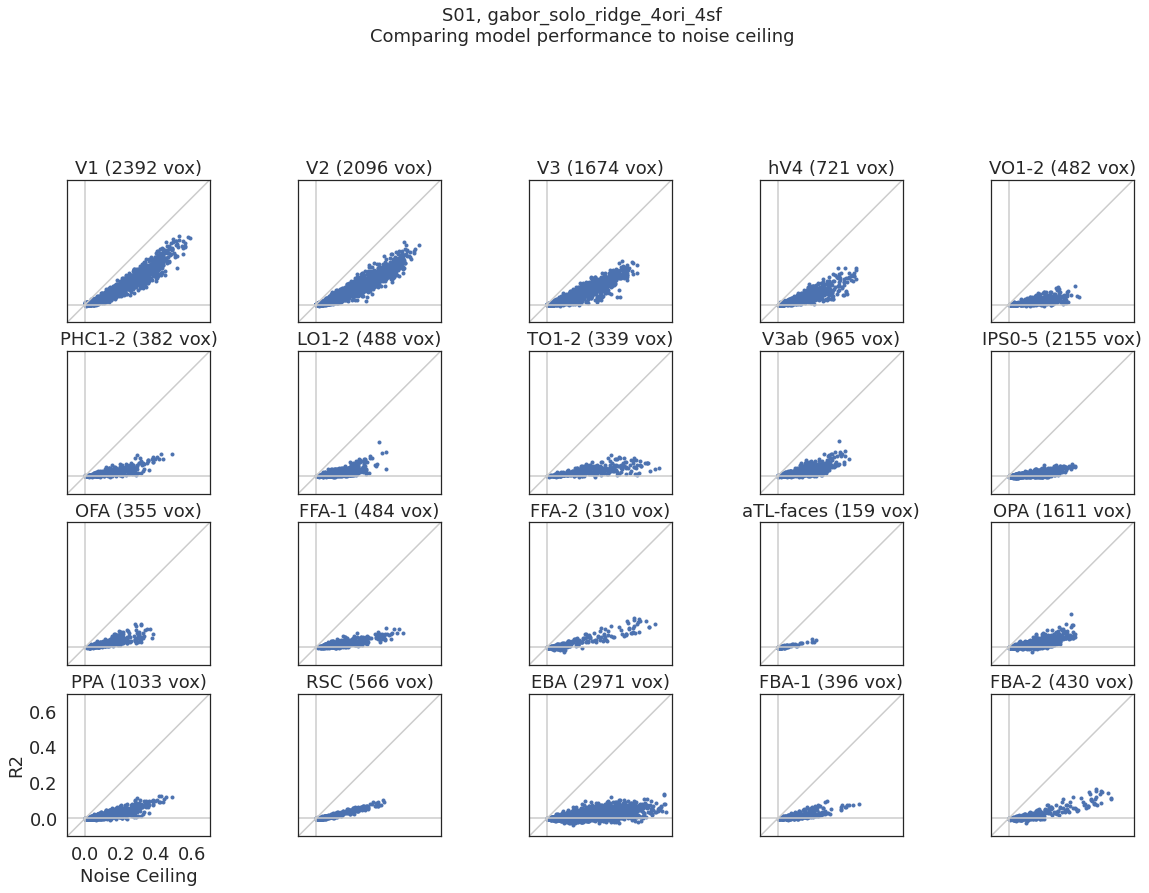

In [156]:
plot_utils.set_all_font_sizes(fs = 18)
summary_plots.plot_r2_vs_nc(subject, fitting_type,out, roi_def=roi_def, skip_inds=skip_inds, \
                            fig_save_folder=fig_save_folder, fig_size=(20,24))

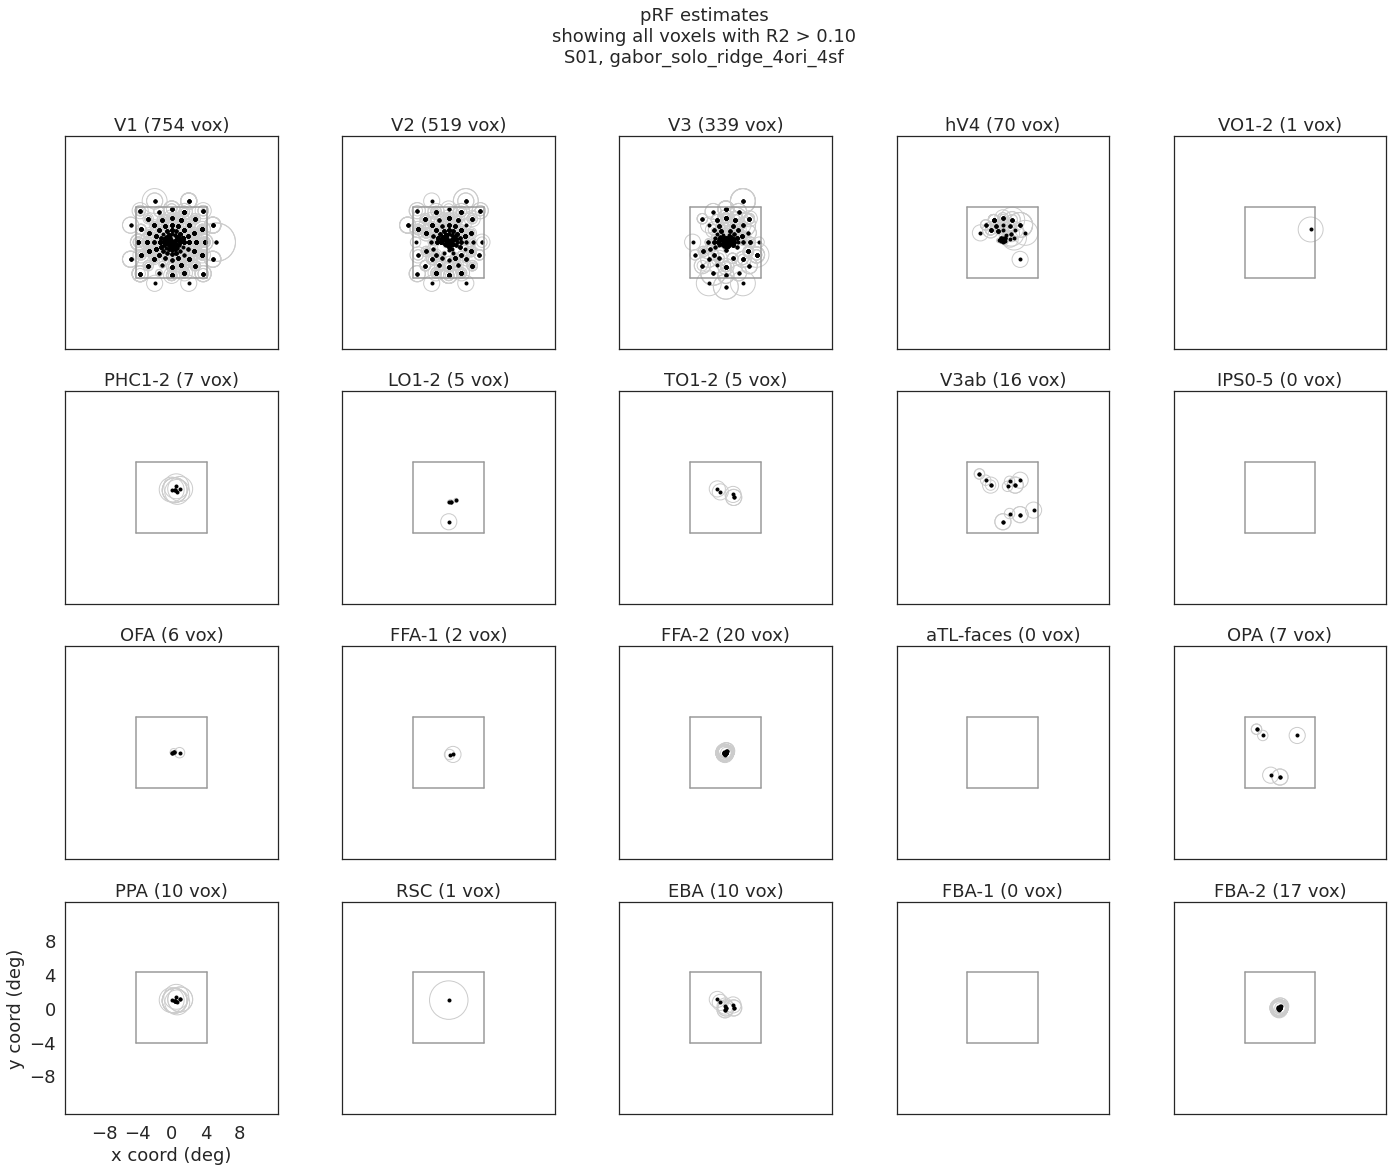

In [157]:
plot_utils.set_all_font_sizes(fs = 18)
plot_prf_params.plot_spatial_rf_circles(subject, fitting_type,out, roi_def=roi_def, skip_inds=skip_inds, \
                                        r2_cutoff = 0.10, fig_save_folder=fig_save_folder)

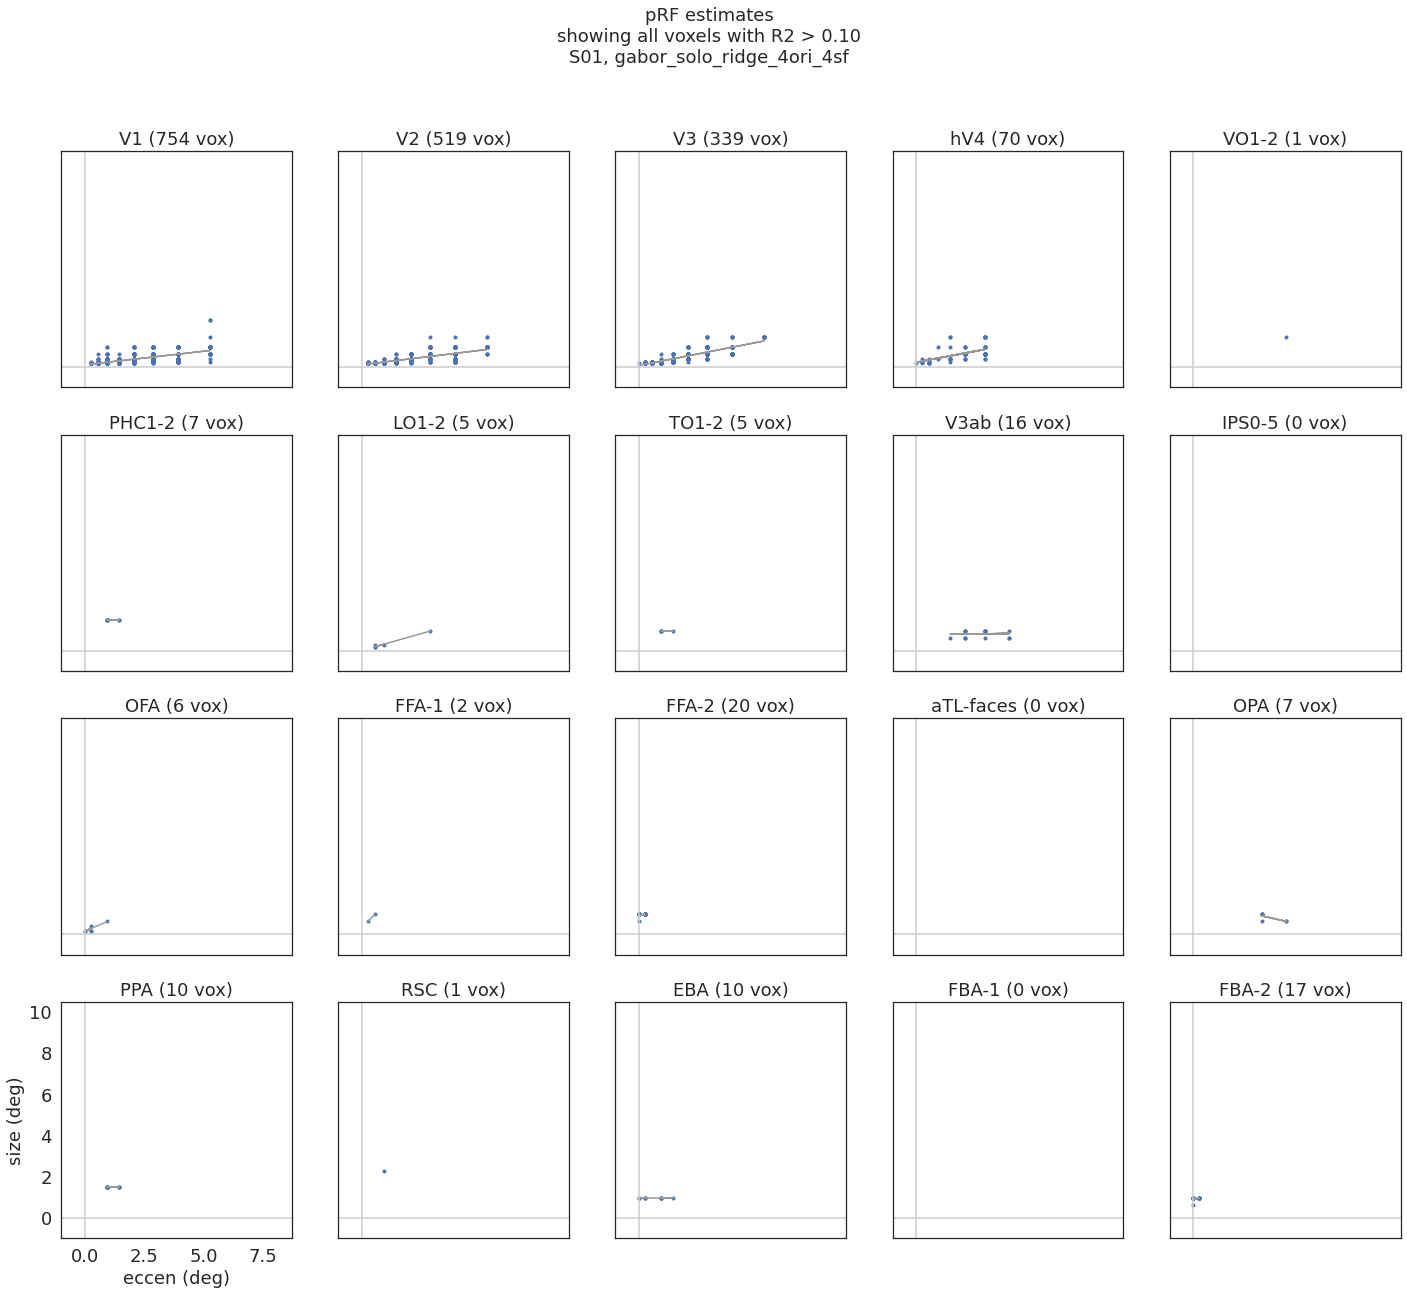

In [158]:
plot_utils.set_all_font_sizes(fs = 18)
plot_prf_params.plot_size_vs_eccen(subject, fitting_type,out, roi_def=roi_def, skip_inds=skip_inds, \
                                        r2_cutoff = 0.10, fig_save_folder=fig_save_folder)

In [150]:
np.max(out['models'][:,2]*8.4)

8.4

Stopping server


In [4]:
nret = len(ret_names)
nface = len(face_names)
nplace = len(place_names)
nbody = len(body_names)    
n_rois = len(ret_names) + len(face_names) + len(place_names) + len(body_names)
roi_names = ret_names+face_names+place_names+body_names

is_ret = np.arange(0, n_rois)<nret
is_face = (np.arange(0, n_rois)>=nret) & (np.arange(0, n_rois)<nret+nface)
is_place = (np.arange(0, n_rois)>=nret+nface) & (np.arange(0, n_rois)<nret+nface+nplace)
is_body = np.arange(0, n_rois)>=nret+nface+nplace


In [5]:
cyc_per_stim = np.array(out['feature_table_complex']['SF: cycles per stim'])
cyc_per_stim = np.unique(cyc_per_stim)
screen_eccen_deg=8.4
cyc_per_deg = cyc_per_stim/screen_eccen_deg

orients_deg = np.array(out['feature_table_complex']['Orientation: degrees'])
orients_deg = np.unique(orients_deg)

feature_weights = out['best_params'][1][:,:,0]
feature_corr = out['corr_each_feature']
n_voxels = feature_weights.shape[0]
n_ori = len(np.unique(orients_deg))
n_sf = len(np.unique(cyc_per_stim))

allw_reshaped = np.reshape(feature_weights, [n_voxels, n_ori, n_sf], order='F')
mean_orient_weights = np.mean(allw_reshaped, axis=2)
print(np.shape(mean_orient_weights))
mean_sf_weights = np.mean(allw_reshaped, axis=1)
print(np.shape(mean_sf_weights))

allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
print(np.shape(mean_orient_corr))
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)
print(np.shape(mean_sf_corr))

# find maxes. if they are constant across orient/SF, then set to nan.
preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_orient_corr[:,0:1], [1,n_ori])==mean_orient_corr, axis=1)
preferred_ori_corr[is_constant] = np.nan

preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_sf_corr[:,0:1], [1,n_sf])==mean_sf_corr, axis=1)
preferred_sf_corr[is_constant] = np.nan

preferred_ori_weights = np.argmax(mean_orient_weights, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_orient_weights[:,0:1], [1,n_ori])==mean_orient_weights, axis=1)
preferred_ori_weights[is_constant] = np.nan

preferred_sf_weights = np.argmax(mean_sf_weights, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_sf_weights[:,0:1], [1,n_sf])==mean_sf_weights, axis=1)
preferred_sf_weights[is_constant] = np.nan

(19738, 12)
(19738, 8)
(19738, 12)
(19738, 8)


In [6]:
# Make plots in pycortex 

import cortex

port=33333

vox2plot = out['val_r2'][:,0]>0.01

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out);
names = ['pRF eccentricity', 'pRF angle', 'pRF size']
maps = [best_ecc_deg, best_angle_deg, best_size_deg]
cmaps = ['PRGn', 'Retinotopy_RYBCR', 'PRGn']
mins = [0,0,0]
maxes = [10, 360, 8]


maps += [np.sqrt(out['val_r2'][:,0])]
names += ['gabor model R2 (sqrt)']
cmaps += ['PuBu']
mins += [0]
maxes += [0.6]

maps += [orients_deg[preferred_ori_corr.astype('int')], cyc_per_deg[preferred_sf_corr.astype('int')]]
names += ['Preferred orientation (deg)', 'Preferred spatial frequency (cyc/deg)']
cmaps += ['Retinotopy_RYBCR', 'viridis']
mins += [0, 0]
maxes += [180, 9]

discrim_each_axis = out['discrim_each_axis']
discrim_type_list = ['indoor_outdoor','animacy','person','food','vehicle','animal']
n_sem_axes = len(discrim_type_list)
maps += [discrim_each_axis[:,dd] for dd in range(n_sem_axes)]
names += ['dprime: %s'%dd for dd in discrim_type_list]
cmaps += ['RdBu' for dd in range(n_sem_axes)]
mins += [-1.5 for dd in range(n_sem_axes)]
maxes += [1.5 for dd in range(n_sem_axes)]



plot_utils.plot_maps_pycortex(maps, names, subject, out, roi_def=roi_def, vox2plot=vox2plot, \
                              fitting_type=fitting_type, \
                              port=port, cmaps=cmaps, mins=mins, maxes=maxes)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


Data is in 3d volume space
navigate browser to: 127.0.0.1:33333
Started server on port 33333


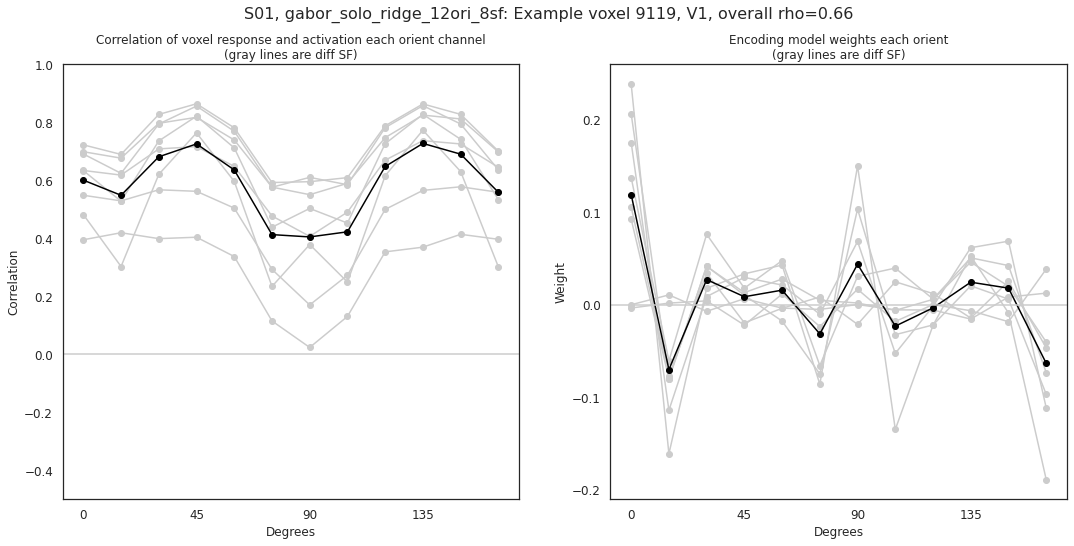

In [195]:
# Plotting orientation tuning for one example voxel

val_cc = out['val_cc'][:,0]
orients_deg
vidx = np.argsort(np.nan_to_num(val_cc))[-1] # choosing vox w best validation set performance
if ~np.isnan(retlabs[vidx]):
    rname = ret_names[int(retlabs[vidx])]
elif ~np.isnan(facelabs[vidx]):
    rname = face_names[int(facelabs[vidx])]
elif ~np.isnan(placelabs[vidx]):
    rname = place_names[int(placelabs[vidx])]
elif ~np.isnan(bodylabs[vidx]):
    rname = body_names[int(bodylabs[vidx])]
else:
    raise ValueError('vidx not found')
plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.plot(orients_deg, allcorr_reshaped[vidx,:,:],'-o',color=[0.8, 0.8, 0.8])
plt.plot(orients_deg,  mean_orient_corr[vidx,:],'-o',color='k')
plt.xlabel('Degrees')
plt.ylabel('Correlation')
plt.title('Correlation of voxel response and activation each orient channel\n(gray lines are diff SF)')
# plt.axhline(val_cc[vidx],color='k')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(0,179,45))
plt.ylim([-0.5,1])

plt.subplot(1,2,2)
plt.plot(orients_deg, allw_reshaped[vidx,:,:],'-o',color=[0.8, 0.8, 0.8])
plt.plot(orients_deg, mean_orient_weights[vidx,:],'-o',color='k')
plt.xlabel('Degrees')
plt.ylabel('Weight')
plt.title('Encoding model weights each orient\n(gray lines are diff SF)')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(0,179,45))
# plt.ylim([-1,1])

plt.suptitle('S%02d, %s: Example voxel %d, %s, overall rho=%.2f'%( subject, \
               fitting_type, vidx, rname, val_cc[vidx]),fontsize=16);



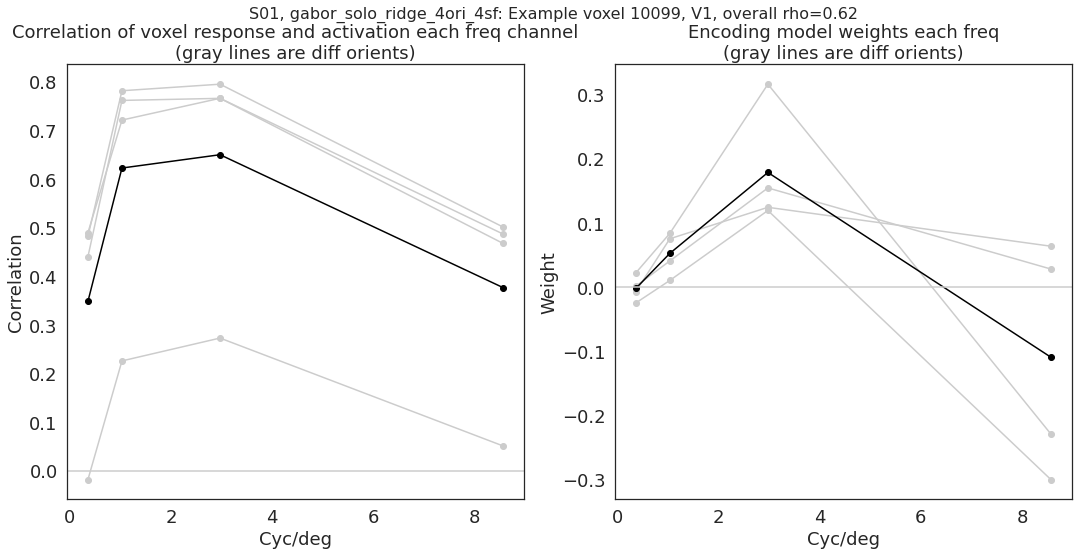

In [163]:
# Plotting orientation tuning for one example voxel

val_cc = out['val_cc'][:,0]
vidx = np.argsort(np.nan_to_num(val_cc))[-1] # choosing vox w best validation set performance
if ~np.isnan(retlabs[vidx]):
    rname = ret_names[int(retlabs[vidx])]
elif ~np.isnan(facelabs[vidx]):
    rname = face_names[int(facelabs[vidx])]
elif ~np.isnan(placelabs[vidx]):
    rname = place_names[int(placelabs[vidx])]
elif ~np.isnan(bodylabs[vidx]):
    rname = body_names[int(bodylabs[vidx])]
else:
    raise ValueError('vidx not found')
plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.plot(cyc_per_deg, allcorr_reshaped[vidx,:,:].T,'-o',color=[0.8, 0.8, 0.8])
plt.plot(cyc_per_deg,  mean_sf_corr[vidx,:],'-o',color='k')
plt.xlabel('Cyc/deg')
plt.ylabel('Correlation')
plt.title('Correlation of voxel response and activation each freq channel\n(gray lines are diff orients)')
# plt.axhline(val_cc[vidx],color='k')
plt.axhline(0, color=[0.8, 0.8, 0.8])
# plt.xticks(np.arange(0,179,45))
# plt.ylim([-0.5,1])

plt.subplot(1,2,2)
plt.plot(cyc_per_deg, allw_reshaped[vidx,:,:].T,'-o',color=[0.8, 0.8, 0.8])
plt.plot(cyc_per_deg, mean_sf_weights[vidx,:],'-o',color='k')
plt.xlabel('Cyc/deg')
plt.ylabel('Weight')
plt.title('Encoding model weights each freq\n(gray lines are diff orients)')
plt.axhline(0, color=[0.8, 0.8, 0.8])
# plt.xticks(np.arange(0,179,45))
# plt.ylim([-1,1])

plt.suptitle('S%02d, %s: Example voxel %d, %s, overall rho=%.2f'%( subject, \
               fitting_type, vidx, rname, val_cc[vidx]),fontsize=16);



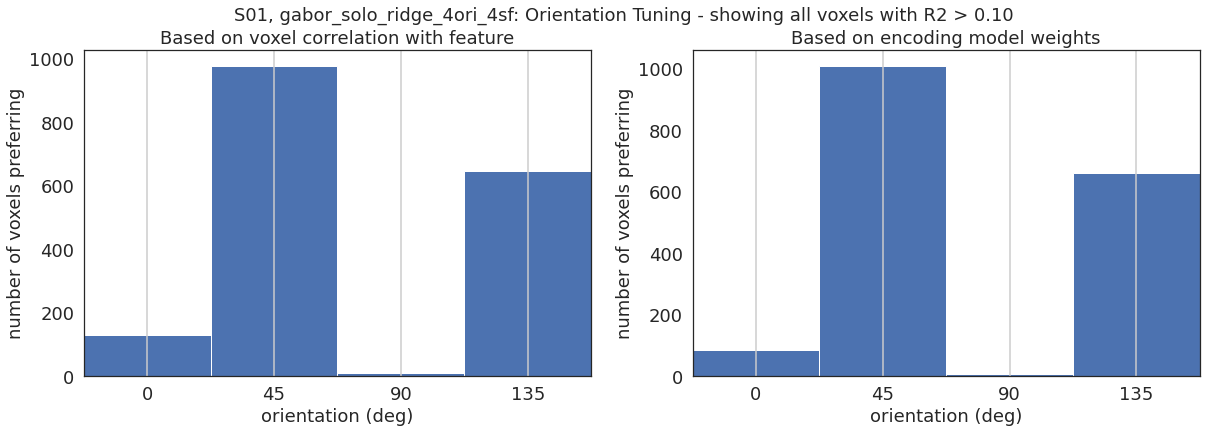

In [164]:
# Plot histogram of the orientation "tuning preferences" based on correlation coefficients
plt.figure(figsize=(20,6))

r2_cutoff = 0.10
val_r2 = out['val_r2'][:,0]
abv_thresh = val_r2>r2_cutoff

plt.subplot(1,2,1)
spacing = orients_deg[1] - orients_deg[0]
neach = [np.sum(preferred_ori_corr[abv_thresh]==oo) for oo in range(n_ori)]
plt.bar(orients_deg, neach, width=spacing)
plt.xticks(np.arange(0,181,45))
plt.xlim([-spacing/2,180-spacing/2])
plt.xlabel('orientation (deg)')
plt.ylabel('number of voxels preferring')
plt.title('Based on voxel correlation with feature')
for ii in np.arange(0,181,45):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
    
plt.subplot(1,2,2)
neach = [np.sum(preferred_ori_weights[abv_thresh]==oo) for oo in range(n_ori)]
plt.bar(orients_deg, neach, width=spacing)
plt.xticks(np.arange(0,181,45))
plt.xlim([-spacing/2,180-spacing/2])
plt.xlabel('orientation (deg)')
plt.ylabel('number of voxels preferring')
plt.title('Based on encoding model weights')
for ii in np.arange(0,181,45):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
     
plt.suptitle('S%02d, %s: Orientation Tuning - showing all voxels with R2 > %.2f'%(subject, fitting_type, r2_cutoff));

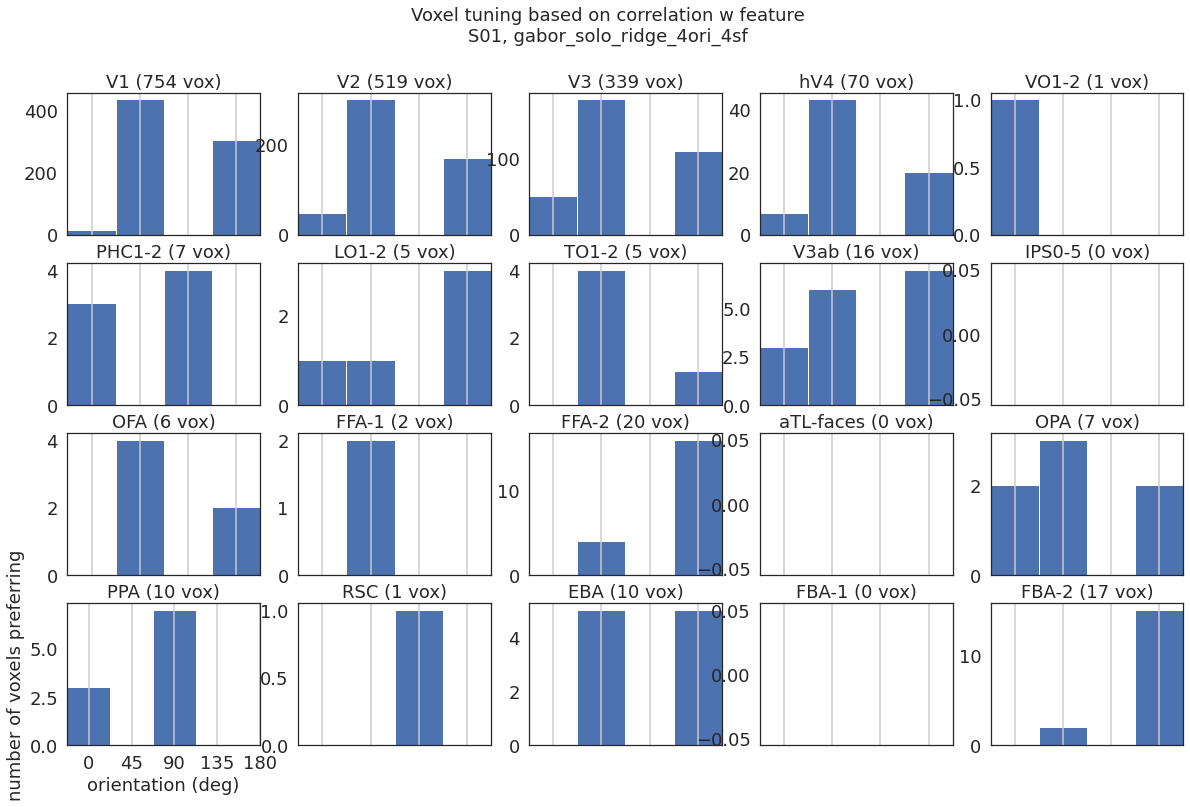

In [165]:

r2_cutoff = 0.10
val_r2 = out['val_r2'][:,0]
abv_thresh = val_r2>r2_cutoff


plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois-len(skip_inds))))
npx = int(np.ceil((n_rois-len(skip_inds))/npy))

pi=0
for rr in range(n_rois):

    if rr not in skip_inds:
        if is_ret[rr]:
            inds_this_roi = retlabs==rr
            rname = ret_names[rr]
        elif is_face[rr]:
            inds_this_roi = facelabs==(rr-nret)
            rname = face_names[rr-nret]
        elif is_place[rr]:
            inds_this_roi = placelabs==(rr-nret-nface)
            rname = place_names[rr-nret-nface]
        elif is_body[rr]:
            inds_this_roi = bodylabs==(rr-nret-nface-nplace)
            rname = body_names[rr-nret-nface-nplace]

        inds_this_roi = inds_this_roi & abv_thresh
        pi+=1
        plt.subplot(npx,npy,pi)

        spacing = orients_deg[1] - orients_deg[0]
        neach = [np.sum(preferred_ori_corr[inds_this_roi]==oo) for oo in range(n_ori)]
        plt.bar(orients_deg, neach, width=spacing)
        
        plt.xlim([-spacing/2,180-spacing/2])

#         print(pi)
        if pi==(npx-1)*npy+1:
            plt.xlabel('orientation (deg)')
            plt.ylabel('number of voxels preferring')
            plt.xticks(np.arange(0,181,45))
        else:
            plt.xticks([]);
    #         plt.yticks([])

        for ii in np.arange(0,181,45):
            plt.axvline(ii,color=[0.8, 0.8, 0.8])
    
        plt.title('%s (%d vox)'%(rname, np.sum(inds_this_roi)))

plt.suptitle('Voxel tuning based on correlation w feature\nS%02d, %s'%(subject, fitting_type));


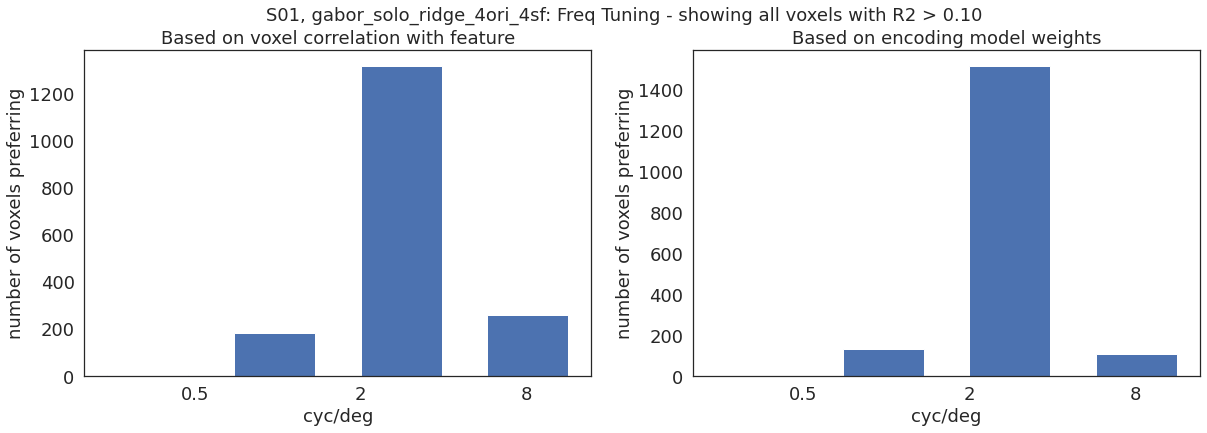

In [166]:
# Plot histogram of the orientation "tuning preferences" based on correlation coefficients
plt.figure(figsize=(20,6))

r2_cutoff = 0.10
val_r2 = out['val_r2'][:,0]
abv_thresh = val_r2>r2_cutoff

plt.subplot(1,2,1)
spacing = np.diff(cyc_per_deg)
if len(spacing)>1:
    dlog = np.log(spacing[1]) - np.log(spacing[0])                
else:
    dlog = np.log(cyc_per_deg[1]) - np.log(cyc_per_deg[0])
    plt.xlim([10**np.log10(0.1), 10**np.log10(14)])
spacing = np.concatenate([[np.exp(np.log(spacing[0]) - dlog)], spacing])
neach = [np.sum(preferred_sf_corr[abv_thresh]==sf) for sf in range(n_sf)]
plt.bar(cyc_per_deg, neach, width=spacing)
plt.gca().set_xscale('log')
plt.xticks([10**np.log10(0.5), 10**np.log10(2),10**np.log10(8)],\
                       [0.5, 2,8])
plt.xlabel('cyc/deg')
plt.ylabel('number of voxels preferring')
plt.title('Based on voxel correlation with feature')

plt.subplot(1,2,2)
spacing = np.diff(cyc_per_deg)
if len(spacing)>1:
    dlog = np.log(spacing[1]) - np.log(spacing[0])                
else:
    dlog = np.log(cyc_per_deg[1]) - np.log(cyc_per_deg[0])
    plt.xlim([10**np.log10(0.1), 10**np.log10(14)])
spacing = np.concatenate([[np.exp(np.log(spacing[0]) - dlog)], spacing])
neach = [np.sum(preferred_sf_weights[abv_thresh]==sf) for sf in range(n_sf)]
plt.bar(cyc_per_deg, neach, width=spacing)
plt.gca().set_xscale('log')
plt.xticks([10**np.log10(0.5), 10**np.log10(2),10**np.log10(8)],\
                       [0.5, 2,8])
plt.xlabel('cyc/deg')
plt.ylabel('number of voxels preferring')
plt.title('Based on encoding model weights')

plt.suptitle('S%02d, %s: Freq Tuning - showing all voxels with R2 > %.2f'%(subject, fitting_type, r2_cutoff));

In [167]:
neach

[1, 136, 1520, 110]

In [128]:
spacing

array([8.21428571])

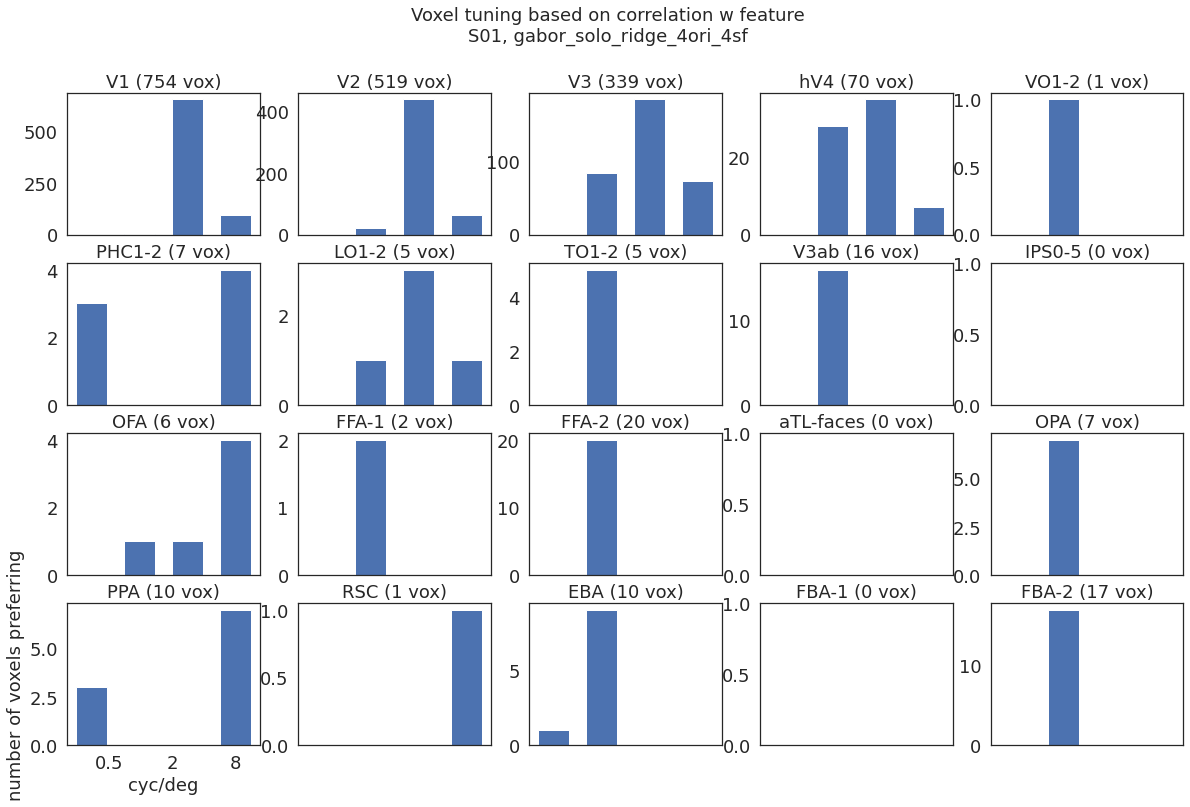

In [168]:

r2_cutoff = 0.10
val_r2 = out['val_r2'][:,0]
abv_thresh = val_r2>r2_cutoff


plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois-len(skip_inds))))
npx = int(np.ceil((n_rois-len(skip_inds))/npy))

pi=0
for rr in range(n_rois):

    if rr not in skip_inds:
        if is_ret[rr]:
            inds_this_roi = retlabs==rr
            rname = ret_names[rr]
        elif is_face[rr]:
            inds_this_roi = facelabs==(rr-nret)
            rname = face_names[rr-nret]
        elif is_place[rr]:
            inds_this_roi = placelabs==(rr-nret-nface)
            rname = place_names[rr-nret-nface]
        elif is_body[rr]:
            inds_this_roi = bodylabs==(rr-nret-nface-nplace)
            rname = body_names[rr-nret-nface-nplace]

        pi+=1
        plt.subplot(npx,npy,pi)
        inds_this_roi = inds_this_roi & abv_thresh
        if np.any(inds_this_roi):


            spacing = np.diff(cyc_per_deg)            
            if len(spacing)>1:
                dlog = np.log(spacing[1]) - np.log(spacing[0])                
            else:
                dlog = np.log(cyc_per_deg[1]) - np.log(cyc_per_deg[0])
                plt.xlim([10**np.log10(0.1), 10**np.log10(14)])
            spacing = np.concatenate([[np.exp(np.log(spacing[0]) - dlog)], spacing])
            neach = [np.sum(preferred_sf_corr[inds_this_roi]==sf) for sf in range(n_sf)]
            plt.bar(cyc_per_deg, neach, width=spacing)
    #         plt.bar(cyc_per_deg, neach)
    #         plt.plot(cyc_per_deg, neach, '.', color='k')
            
        plt.gca().set_xscale('log')
        if pi==(npx-1)*npy+1:
            plt.xlabel('cyc/deg')
            plt.ylabel('number of voxels preferring')
            plt.xticks([10**np.log10(0.5), 10**np.log10(2),10**np.log10(8)],\
                       [0.5, 2,8])
        else:
            plt.xticks([]);
        #         plt.yticks([])

    #         for ii in np.arange(0,181,45):
    #             plt.axvline(ii,color=[0.8, 0.8, 0.8])

        plt.title('%s (%d vox)'%(rname, np.sum(inds_this_roi)))

plt.suptitle('Voxel tuning based on correlation w feature\nS%02d, %s'%(subject, fitting_type));


In [183]:
discrim_each_axis = out['discrim_each_axis']
discrim_type_list = ['indoor_outdoor','animacy','person','food','vehicle','animal']
n_sem_axes = len(discrim_type_list)
mean_discrim_each_roi = np.zeros((n_rois, n_sem_axes))

for rr in range(n_rois):
    if rr not in skip_inds:
        if is_ret[rr]:
            inds_this_roi = retlabs==rr
        elif is_face[rr]:
            inds_this_roi = facelabs==(rr-nret)
        elif is_place[rr]:
            inds_this_roi = placelabs==(rr-nret-nface)
        elif is_body[rr]:
            inds_this_roi = bodylabs==(rr-nret-nface-nplace)
        mean_discrim_each_roi[rr,:] = np.mean(np.abs(discrim_each_axis[inds_this_roi,:]), axis=0)
    else:
        mean_discrim_each_roi[rr,:] = np.nan

In [187]:
np.any(np.sum(np.isnan(discrim_each_axis), axis=1))

False

In [186]:
out['which_prf_grid']

5

In [188]:
out['up_to_sess']

40

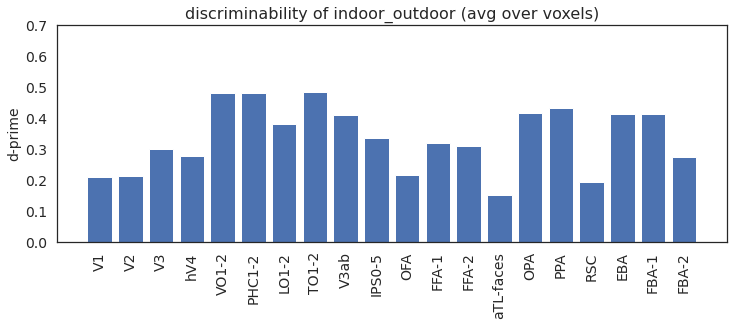

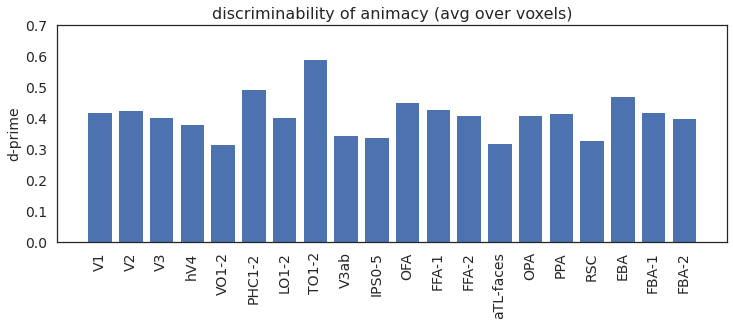

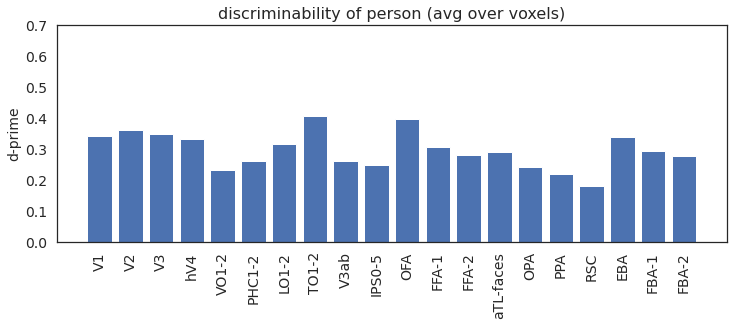

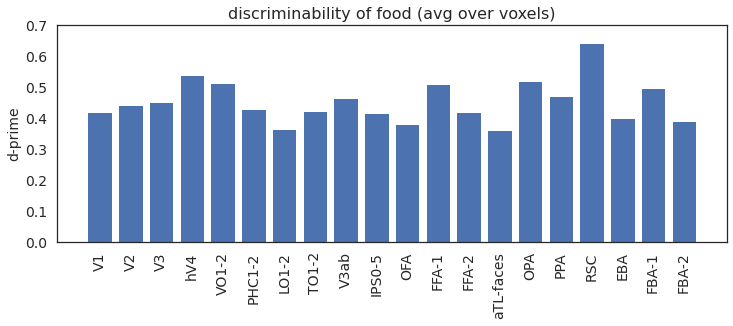

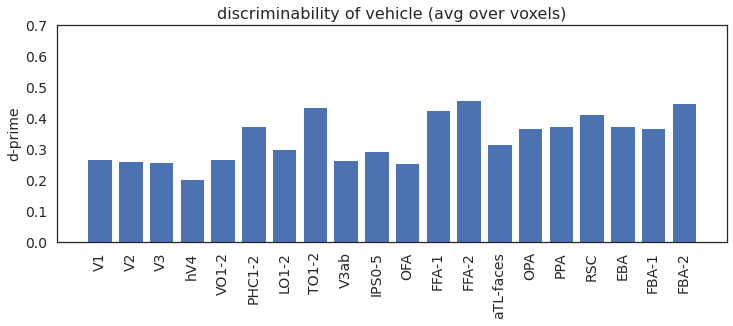

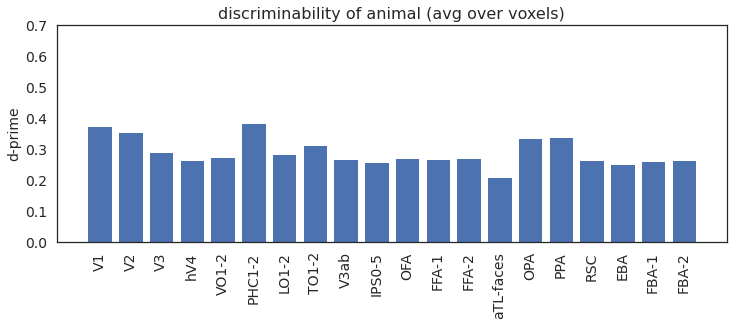

In [184]:

for aa, discrim_type in enumerate(discrim_type_list):
    plt.figure(figsize=(12,4));
    inds2use = ~np.isin(np.arange(n_rois), skip_inds)
#     inds2use = ~np.isnan(dprime_vals[:,aa])
    n_rois_plot = np.sum(inds2use)
    plt.bar(np.arange(n_rois_plot),mean_discrim_each_roi[inds2use,aa])
    plt.xticks(np.arange(n_rois_plot), labels=np.array(roi_names)[inds2use], rotation=90);
    plt.ylabel('d-prime')
    plt.title('discriminability of %s (avg over voxels)'%discrim_type)
    plt.ylim([0,0.7])

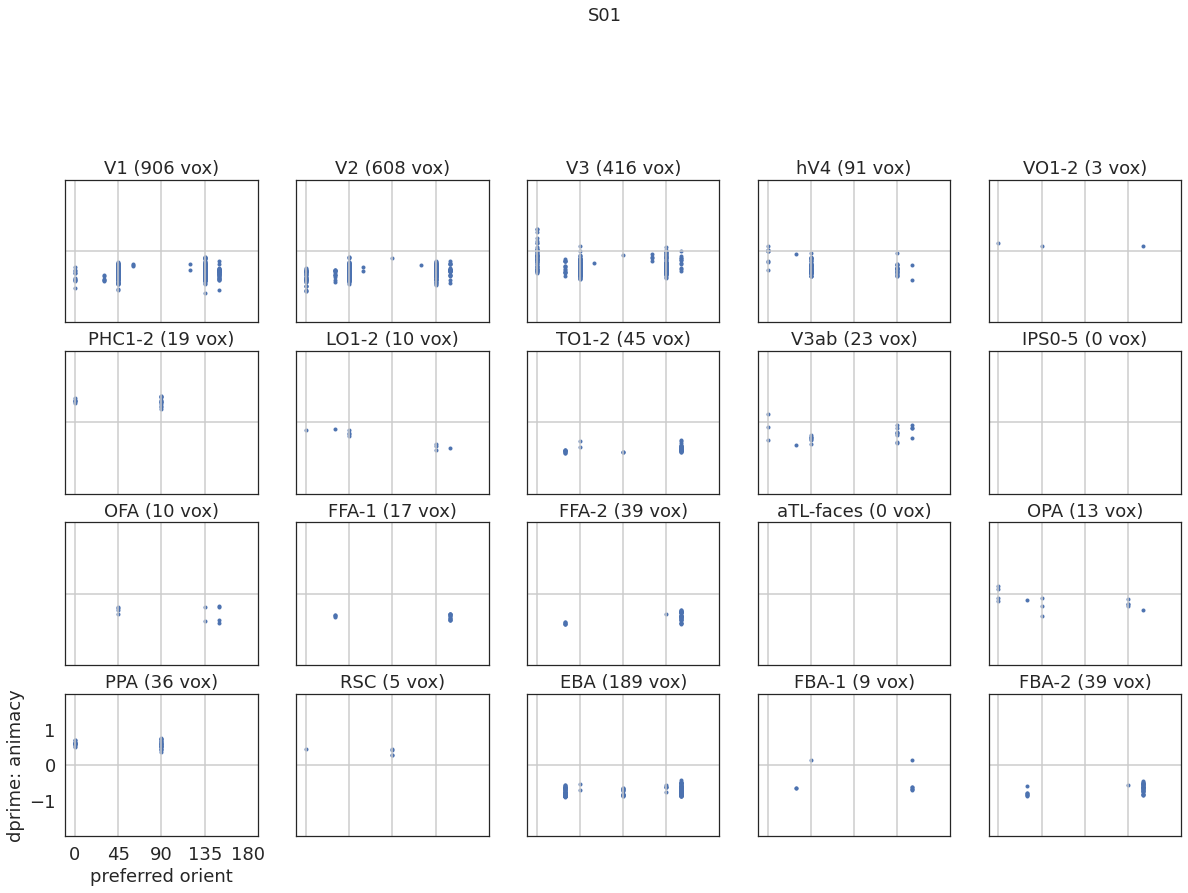

In [107]:
plot_utils.set_all_font_sizes(fs = 18)
r2_cutoff = 0.10
dd = 1
val1 = orients_deg[preferred_ori_corr.astype(int)]
val2 = out['discrim_each_axis'][:,dd]
dat = np.concatenate((val1[:,np.newaxis],val2[:,np.newaxis]), axis=1)

inds2use = out['val_r2'][:,0]>r2_cutoff

sp = plot_utils.scatter_plot(color=None, xlabel='preferred orient', \
                             ylabel='dprime: %s'%discrim_type_list[dd], \
                             xlims=[-10,190], ylims=[-2,2], \
                  xticks=np.arange(0,181,45), yticks=([-1,0,1]),\
                  show_diagonal=False, show_axes=True, square=False);

plot_utils.create_roi_subplots(dat, inds2use, sp, subject, out,\
                    suptitle='S%02d'%(subject), \
                   label_just_corner=True, figsize=(20,24), roi_def=roi_def, skip_inds=skip_inds)

plt.gcf().subplots_adjust(bottom=0.5)
axes = plt.gcf().get_axes();
for ax in axes:
    for ii in np.arange(45,136,45):
        ax.axvline(ii, color=[0.8, 0.8, 0.8])
#     print(ax)
#     plt.axvline(90, figure=ax);

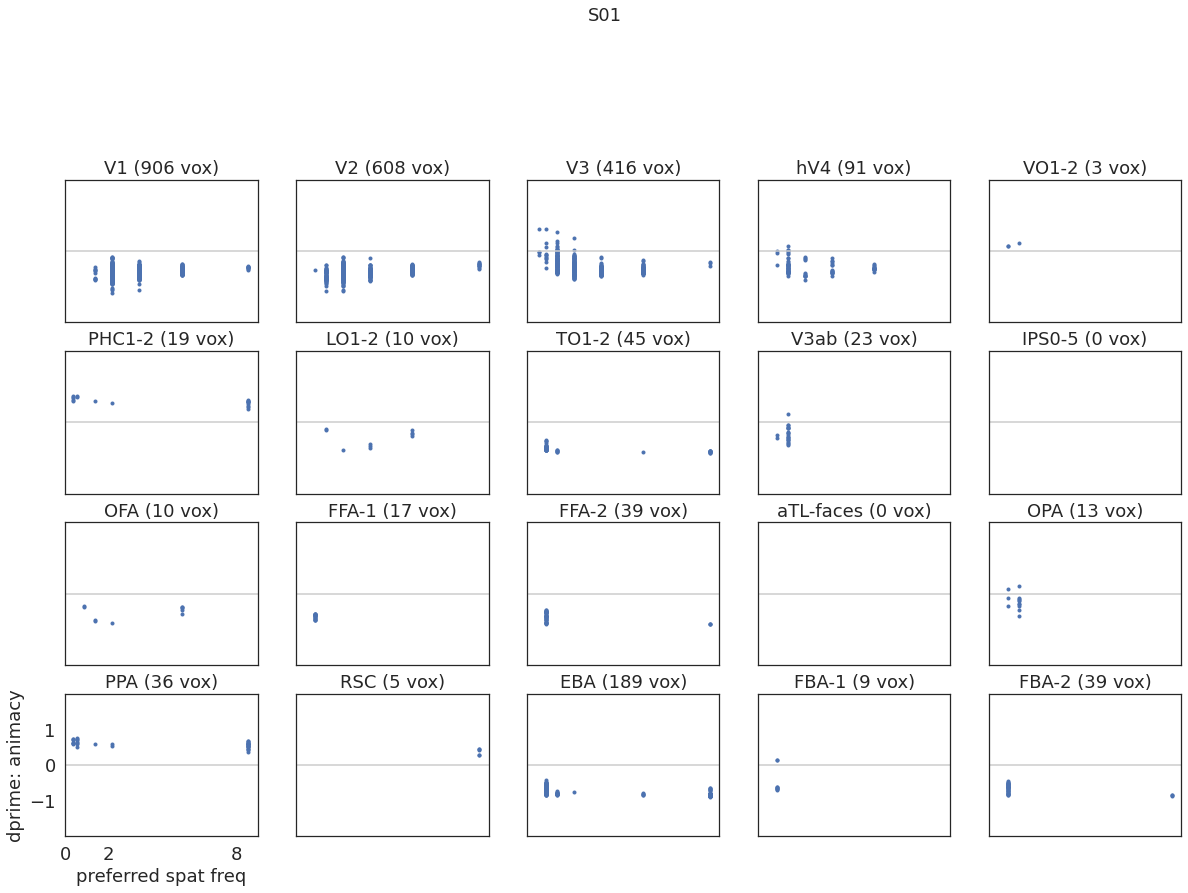

In [108]:
plot_utils.set_all_font_sizes(fs = 18)
r2_cutoff = 0.10
dd = 1
val1 = cyc_per_deg[preferred_sf_corr.astype(int)]
val2 = out['discrim_each_axis'][:,dd]
dat = np.concatenate((val1[:,np.newaxis],val2[:,np.newaxis]), axis=1)

inds2use = out['val_r2'][:,0]>r2_cutoff

sp = plot_utils.scatter_plot(color=None, xlabel='preferred spat freq', \
                             ylabel='dprime: %s'%discrim_type_list[dd], \
                             xlims=[0,9], ylims=[-2,2], \
                  xticks=[0,2,8], yticks=([-1,0,1]),\
                  show_diagonal=False, show_axes=True, square=False);

plot_utils.create_roi_subplots(dat, inds2use, sp, subject, out,\
                    suptitle='S%02d'%(subject), \
                   label_just_corner=True, figsize=(20,24), roi_def=roi_def, skip_inds=skip_inds)

plt.gcf().subplots_adjust(bottom=0.5)
axes = plt.gcf().get_axes();
# for ax in axes:
#     for ii in np.arange(45,136,45):
#         ax.axvline(ii, color=[0.8, 0.8, 0.8])
#     print(ax)
#     plt.axvline(90, figure=ax);

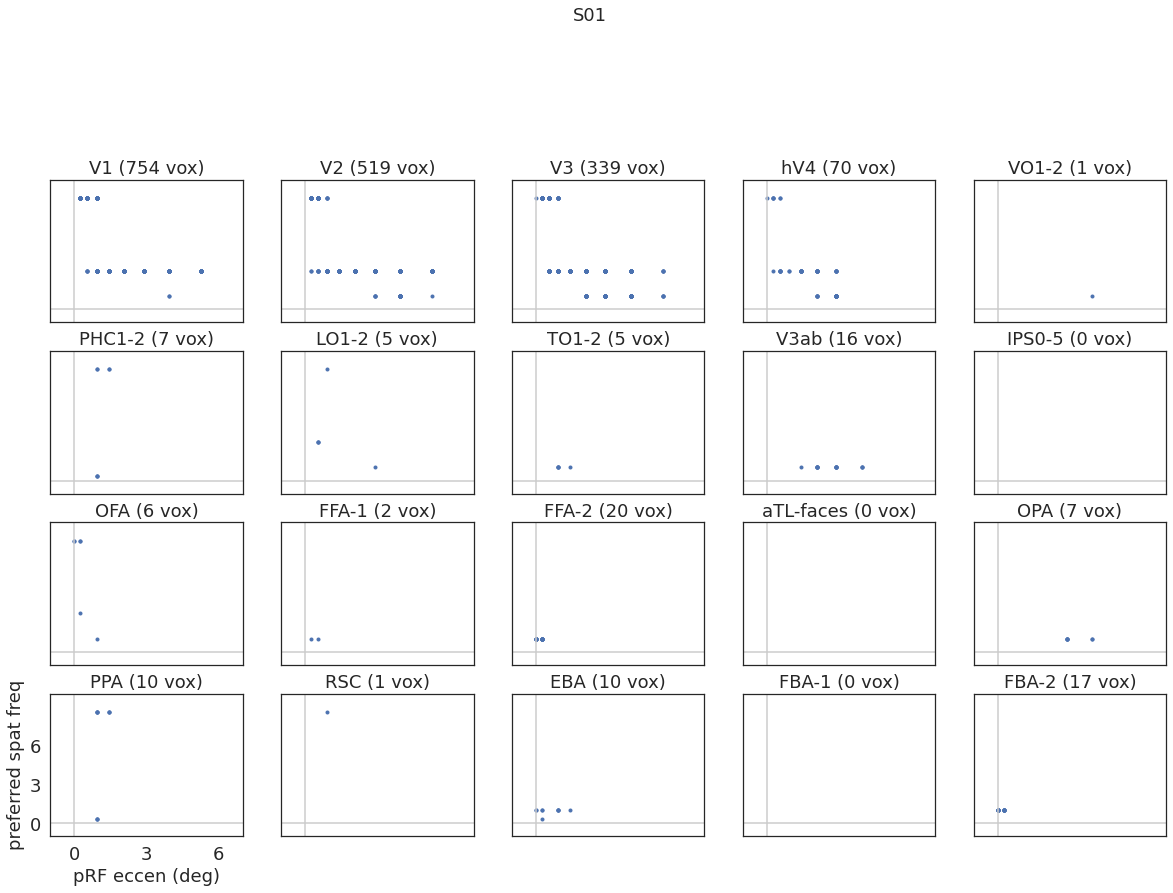

In [172]:
plot_utils.set_all_font_sizes(fs = 18)
r2_cutoff = 0.10

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out, screen_eccen_deg=8.4)

val1 = best_ecc_deg
val2 = cyc_per_deg[preferred_sf_corr.astype('int')]
dat = np.concatenate((val1[:,np.newaxis],val2[:,np.newaxis]), axis=1)

inds2use = out['val_r2'][:,0]>r2_cutoff

sp = plot_utils.scatter_plot(color=None, xlabel='pRF eccen (deg)', \
                             ylabel='preferred spat freq', \
                             xlims=[-1,7], ylims=[-1,10], \
                  xticks=[0,3,6], yticks=([0,3,6]),\
                  show_diagonal=False, show_axes=True, square=False);

plot_utils.create_roi_subplots(dat, inds2use, sp, subject, out,\
                    suptitle='S%02d'%(subject), \
                   label_just_corner=True, figsize=(20,24), roi_def=roi_def, skip_inds=skip_inds)

plt.gcf().subplots_adjust(bottom=0.5)
axes = plt.gcf().get_axes();
# for ax in axes:
#     for ii in np.arange(45,136,45):
#         ax.axvline(ii, color=[0.8, 0.8, 0.8])
#     print(ax)
#     plt.axvline(90, figure=ax);

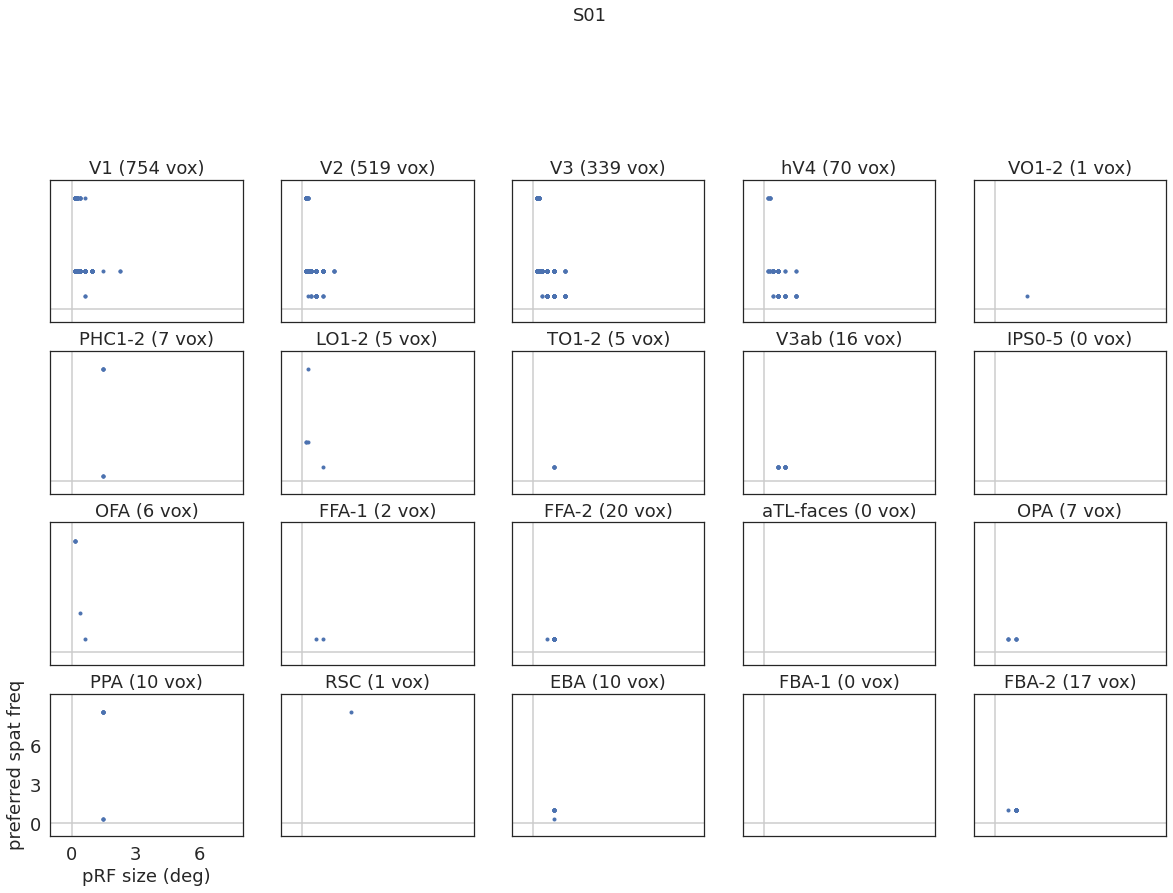

In [171]:
plot_utils.set_all_font_sizes(fs = 18)
r2_cutoff = 0.10

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out, screen_eccen_deg=8.4)
val1 = best_size_deg
val2 = cyc_per_deg[preferred_sf_corr.astype(int)]
dat = np.concatenate((val1[:,np.newaxis],val2[:,np.newaxis]), axis=1)

inds2use = out['val_r2'][:,0]>r2_cutoff

sp = plot_utils.scatter_plot(color=None, xlabel='pRF size (deg)', \
                             ylabel='preferred spat freq', \
                             xlims=[-1,8], ylims=[-1,10], \
                  xticks=[0,3,6], yticks=([0,3,6]),\
                  show_diagonal=False, show_axes=True, square=False);

plot_utils.create_roi_subplots(dat, inds2use, sp, subject, out,\
                    suptitle='S%02d'%(subject), \
                   label_just_corner=True, figsize=(20,24), roi_def=roi_def, skip_inds=skip_inds)

plt.gcf().subplots_adjust(bottom=0.5)
axes = plt.gcf().get_axes();
# for ax in axes:
#     for ii in np.arange(45,136,45):
#         ax.axvline(ii, color=[0.8, 0.8, 0.8])
#     print(ax)
#     plt.axvline(90, figure=ax);